# Урок 6. Градиентный бустинг

In [ ]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

Используем один из "игрушечных" датасетов из той же библиотеки.

In [ ]:
from sklearn.datasets import load_diabetes

In [ ]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [ ]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [ ]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [ ]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [ ]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

# Домашнее задание

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, n_trees, max_depth):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

    return mean_squared_error(y_train, train_prediction), mean_squared_error(y_test, test_prediction)

In [ ]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

Создадим сетку параметров

In [ ]:
xx, yy = np.meshgrid(np.arange(3, 10, 1), np.arange(5, 30, 5))

In [ ]:
params = np.c_[xx.ravel(), yy.ravel()]

In [ ]:
mse_train_list = []
mse_test_list = []

for param in params:
    coefs = [1] * param[1]
    eta = 0.01
    trees, train_errors, test_errors = gb_fit(param[1], param[0], X_train, X_test, y_train, y_test, coefs, eta)
    mse_train, mse_test = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, param[1], param[0])
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)

In [ ]:
s_mse_test_list = ( np.array(mse_test_list) - min(mse_train_list) +10 ) / 100
s_mse_train_list = ( np.array(mse_train_list) - min(mse_train_list) +10 ) / 100


Построим скаттер диграмммы, в которых ошибку отразим через размер каждого значения

Text(0.5, 1.0, 'Ошибка на test')

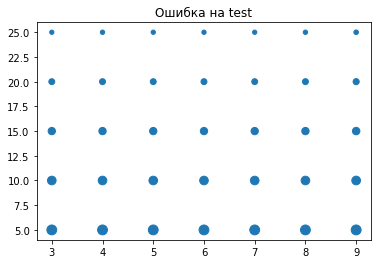

In [ ]:
plt.scatter(params[:, 0], params[:, 1], s=s_mse_test_list)
plt.title('Ошибка на test')

Text(0.5, 1.0, 'Ошибка на train')

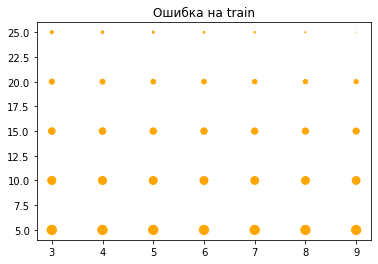

In [ ]:
plt.scatter(params[:, 0], params[:, 1], s=s_mse_train_list, color='orange')
plt.title('Ошибка на train')

Видно, что с ростом максимальной глубилны ошибка на train уменьшается, как и с ростом количества деревье. Тогда как на тесте визуально кажется ничего не изменится.

Построим график связи test от train.

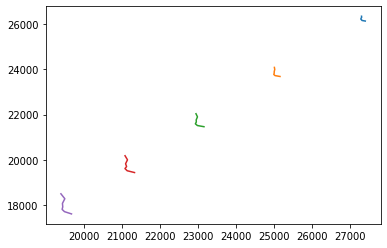

In [ ]:
for i in range(0, 7):
  plt.plot(mse_test_list[7*i:7*(i+1)], mse_train_list[7*i:7*(i+1)])

Видно, что поведение алгоритмов типовое. Построим отедльные графики для каждого из них.

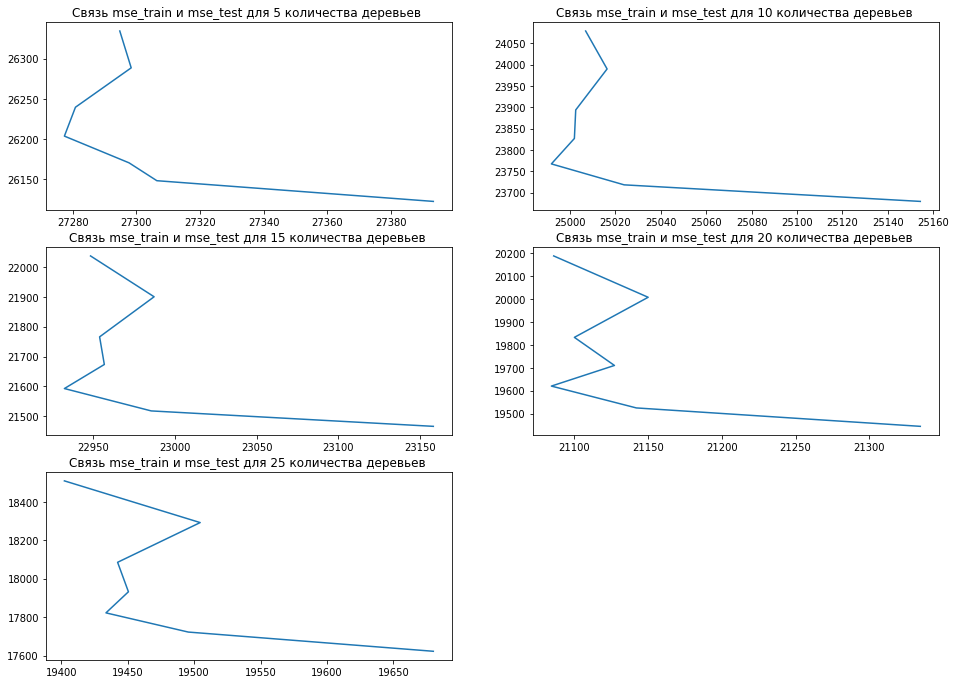

In [ ]:
plt.figure(figsize = (16, 20))
for i in range(0, 5):
  plt.subplot(5,2,i+1)
  plt.title(f'Связь mse_train и mse_test для {(i+1)*5} количества деревьев ')
  plt.plot(mse_test_list[7*i:7*(i+1)], mse_train_list[7*i:7*(i+1)])

На графиках видно, что существуют оптимальные значения. Для малого количества дерьевев оптимальная глубина составляет 6-7. Для большого количества деревьев кажется, что лучший результат достигается на негулбоких деревьях.